In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab


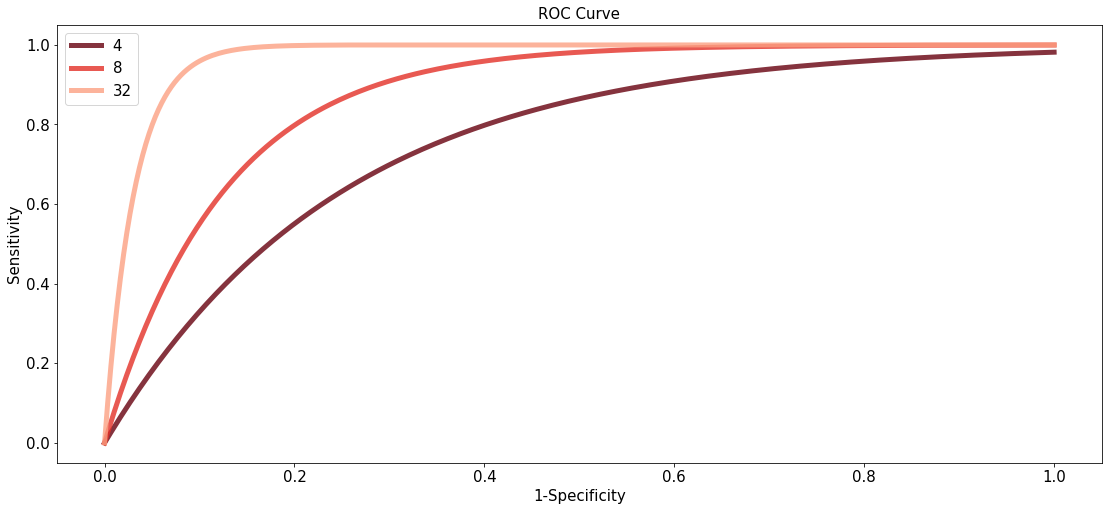

In [44]:
## A) Function for Age Invariant sensitivity  ######################################################################################




def plot_sens_spec_par(sens_spec_par=[4, 8, 32], palette="Blues_r", title="ROC Curve"):
    """
        Function assuming Age Invariant Sensitivity
        Plot ROC curves for different levels of sensibility-specificity par.
    """
    sens_spec_par = np.array(sens_spec_par)

    # Specificity Range
    test_spec = np.linspace(0, 1, 300)
    cm = pylab.get_cmap(palette)


    fig, ax = plt.subplots(1,1,figsize=(15.5, 7.2))
    for idx, sens in enumerate(sens_spec_par):


        NUM_COLORS = len(sens_spec_par)
        color = cm(1.*idx/NUM_COLORS)

        test_sens = 1-np.exp(-sens*(1-test_spec))
        ax.plot(1-test_spec, test_sens, linewidth=5, color=color, alpha=0.8, label=f'{sens}')

    ax.set_ylabel("Sensitivity", fontsize=15)
    ax.set_xlabel("1-Specificity", fontsize=15)
    ax.tick_params( which='both', axis='both', labelsize=15)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=15)
    plt.tight_layout()


# example
plot_sens_spec_par(sens_spec_par=[4, 8, 32], palette="Reds_r")


In [63]:

#'Function to define infection over age
#'
#' @param ages a vector of integers defining all possible ages
#' @param par a vector of integers defining ages where infection occurs
#'
#'@return a vector of length 'ages' containing 1s where infection occurs, and 0s otherwise


def ages_infections_onehot(ages=np.arange(1, 60+1,1), ages_infections = np.arange(5, 7+1, 1)):
    """[summary]

    Args:
        ages ([type], optional): [description]. Defaults to np.arange(1, 60+1,1).
        ages_infections ([type], optional): [description]. Defaults to np.arange(5, 7+1, 1).

    Returns:
        [type]: [description]
    """
    return np.int32(np.isin(ages, ages_infections))

age_infection = ages_infections_onehot()



In [67]:

def hazard_age(mu_b=0.3, mu_immunopath=0.2, mu_disease=0.2, mu_both=0.1, sensibility=0.7, specificity=0.8, ages_infections = np.arange(5, 7+1, 1), ages=np.arange(1, 60+1,1)):
    """[Return hazard over age]

    Args:
        mu_b (float, optional): [Baseline Mortality]. Defaults to 0.3.
        mu_immunopath (float, optional): [Mortality from Immunopathology]. Defaults to 0.2.
        mu_disease (float, optional): [Mortality from infection]. Defaults to 0.2.
        mu_both (float, optional): [Morality where both are occurring]. Defaults to 0.1.
        sensibility (float, optional): [Sensibility]. Defaults to 0.7.
        specificity (float, optional): [Specificity]. Defaults to 0.8.
        ages_infections ([type], optional): [Ages where infection occurs]. Defaults to np.arange(5, 7+1, 1).
        ages ([type], optional): [Ages range]. Defaults to np.arange(1, 60+1,1).
    """
    age_infection =  ages_infections_onehot(ages=ages, ages_infections=ages_infections)

    baseline = mu_b                                             # Baseline
    fp       = (1-specificity)*mu_immunopath*(1-age_infection)  # False Positive (not sick, think are)
    fn       = (1-sensibility)*mu_disease*age_infection         # False Negative (are sick, think not)
    tp       = sensibility*mu_both*age_infection                # True Positive (are sick, think are)

    hazard_age    = baseline + fp + fn + tp

    return hazard_age
